# Raster-vector interactions {#raster-vector}

## Prerequisites

In [1]:
#| echo: false
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_rows = 6
pd.options.display.max_columns = 6
pd.options.display.max_colwidth = 35
plt.rcParams['figure.figsize'] = (5, 5)

In [58]:
import numpy as np
import shapely.geometry
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
import rasterio.mask
import rasterstats
from rasterio.plot import show
import math
import os

In [3]:
# 出现错误CRSError: Invalid projection: epsg:4326: 的解决方案
# 因为装了多个版本的pyproj
# 在anaconda的目录下搜一下其他的proj.db文件的路径
# 复制路径在所装的环境文件夹下的Library文件夹下的那个路径，使用pyproj.datadir.set_data_dir()来更新目录
import pyproj
# pyproj.datadir.get_data_dir()
path = 'D:\work\miniconda3\Library\share\proj'
pyproj.datadir.set_data_dir(path)

In [55]:
src_srtm = rasterio.open('data/srtm.tif')
src_nlcd = rasterio.open('data/nlcd.tif')
src_grain = rasterio.open('data/grain.tif')
src_elev = rasterio.open('data/elev.tif')
src_dem = rasterio.open('data/dem.tif')
zion = gpd.read_file('data/zion.gpkg')
zion_points = gpd.read_file('data/zion_points.gpkg')
cycle_hire_osm = gpd.read_file('data/cycle_hire_osm.gpkg')

## 介绍

## 光栅裁剪

许多地理数据项目涉及集成来自许多不同来源的数据，例如遥感图像（栅格）和行政边界（矢量）。 输入栅格数据集的范围通常大于感兴趣区域。 在这种情况下，栅格**裁剪**和**屏蔽**对于统一输入数据的空间范围非常有用。 这两种操作都减少了对象内存的使用和后续分析步骤的相关计算资源，并且可能是创建涉及栅格数据的有吸引力的地图之前必要的预处理步骤。

我们将使用两个对象来说明光栅裁剪：

* 代表犹他州西南部海拔（海拔米）的“srtm.tif”栅格
* 代表锡安国家公园的`zion.gpkg`矢量图层

目标对象和裁剪对象必须具有相同的投影。 以下将向量层“zion”重新投影到栅格“src_srtm”的 CRS 中：

In [5]:
zion = zion.to_crs(src_srtm.crs)

为了屏蔽图像，即将与“zion”多边形不相交的所有像素转换为“无数据”，我们使用“rasterio.mask.mask”函数，如下所示：

In [6]:
out_image_mask, out_transform_mask = rasterio.mask.mask(
    src_srtm, 
    zion['geometry'], 
    crop=False, 
    nodata=9999
)

请注意，我们需要指定与栅格数据类型一致的“无数据”值。 由于“srtm.tif”的类型为“uint16”，因此我们选择“9999”（保证不会出现在栅格中的正整数）。

结果是带有屏蔽值的“out_image”数组：

In [7]:
out_image_mask

array([[[9999, 9999, 9999, ..., 9999, 9999, 9999],
        [9999, 9999, 9999, ..., 9999, 9999, 9999],
        [9999, 9999, 9999, ..., 9999, 9999, 9999],
        ...,
        [9999, 9999, 9999, ..., 9999, 9999, 9999],
        [9999, 9999, 9999, ..., 9999, 9999, 9999],
        [9999, 9999, 9999, ..., 9999, 9999, 9999]]], dtype=uint16)

和新的“out_transform”：

In [8]:
out_transform_mask

Affine(0.0008333333332777796, 0.0, -113.23958321278403,
       0.0, -0.0008333333332777843, 37.512916763165805)

请注意，遮罩（不裁剪！）不会修改栅格空间配置。 因此，新的变换与原始变换相同：

In [9]:
src_srtm.transform

Affine(0.0008333333332777796, 0.0, -113.23958321278403,
       0.0, -0.0008333333332777843, 37.512916763165805)

不幸的是，“out_image”和“out_transform”对象不包含任何指示“9999”表示“无数据”的信息。 要将信息与栅格关联起来，我们必须将其与相应的元数据一起写入文件。 例如，要将裁剪后的栅格写入文件，我们需要修改元数据中的“无数据”设置：

In [10]:
out_meta = src_srtm.meta
out_meta.update(nodata=9999)
out_meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 9999,
 'width': 465,
 'height': 457,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.0008333333332777796, 0.0, -113.23958321278403,
        0.0, -0.0008333333332777843, 37.512916763165805)}

然后我们可以将裁剪后的栅格写入文件：

In [11]:
new_dataset = rasterio.open('output/srtm_masked.tif', 'w', **out_meta)
new_dataset.write(out_image_mask)
new_dataset.close()

现在我们可以重新导入栅格：

In [12]:
src_srtm_mask = rasterio.open('output/srtm_masked.tif')

`.meta` 属性包含 `nodata` 条目。 现在，任何相关操作（例如绘图）都将考虑“无数据”：

In [13]:
src_srtm_mask.meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 9999.0,
 'width': 465,
 'height': 457,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.0008333333332777796, 0.0, -113.23958321278403,
        0.0, -0.0008333333332777843, 37.512916763165805)}

裁剪意味着将栅格范围缩小到矢量图层的范围：

* 要裁剪 * 和 * 蒙版，我们可以在上面显示的 `rasterio.mask.mask` 表达式中使用相同的内容进行蒙版，只需设置 `crop=True` 而不是 `crop=False`。
* 为了仅裁剪，*没有*遮罩，我们可以导出范围多边形，然后使用它进行裁剪。

例如，以下是我们如何获取“zion”的多边形范围，作为“shapely”几何对象：

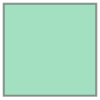

In [14]:
bb = zion.unary_union.envelope
bb

该范围现在可用于屏蔽。 在这里，我们还使用“all_touched=True”选项，以便包含与范围部分重叠的像素：

In [15]:
out_image_crop, out_transform_crop = rasterio.mask.mask(
    src_srtm, 
    [bb], 
    crop=True, 
    all_touched=True, 
    nodata=9999
)

@fig-raster-crop 显示原始栅格以及裁剪和遮罩的结果。

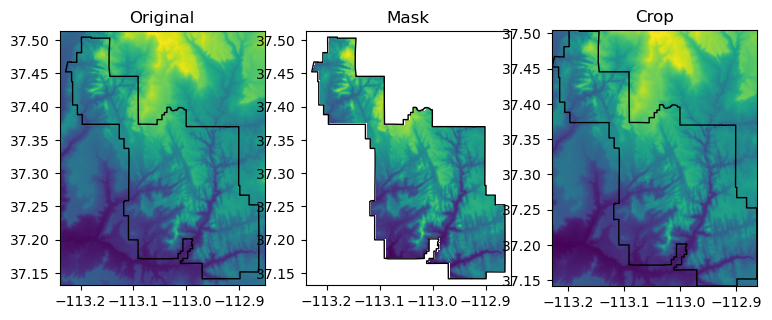

In [16]:
#| label: fig-raster-crop
#| fig-cap: Raster masking and cropping

fig, axes = plt.subplots(ncols=3, figsize=(9,5))
show(src_srtm, ax=axes[0])
zion.plot(ax=axes[0], color='none', edgecolor='black')
show(src_srtm_mask, ax=axes[1])
zion.plot(ax=axes[1], color='none', edgecolor='black')
show(out_image_crop, transform=out_transform_crop, ax=axes[2])
zion.plot(ax=axes[2], color='none', edgecolor='black')
axes[0].set_title('Original')
axes[1].set_title('Mask')
axes[2].set_title('Crop');

## 光栅提取

栅格提取是基于（通常是矢量）地理“选择器”对象识别并返回与特定位置的“目标”栅格关联的值的过程。 栅格提取的逆过程——根据矢量对象分配栅格单元值——是栅格化，在第...节中描述。

在以下示例中，我们使用名为“rasterstats”的第三方包，该包专门用于提取栅格值：

* 到 *points*，通过 `rasterstats.point_query` 函数，或者
* 到 *多边形*，通过 `rasterstats.zonal_stats` 函数。

### 提取点

基本示例是提取特定点处栅格单元的值。 为此，我们将使用“zion_points”，其中包含锡安国家公园内 30 个位置的样本（图...）。 以下表达式从“srtm”中提取高程值：

In [17]:
result = rasterstats.point_query(
    zion_points, 
    src_srtm.read(1), 
    nodata = src_srtm.nodata, 
    affine = src_srtm.transform,
    interpolate='nearest'
)

生成的对象是栅格值的“列表”，对应于“zion_points”：

In [18]:
result[:5]

[1802, 2433, 1886, 1370, 1452]

要创建一个带有点 ID（每个向量行一个值）和每个点的相关“srtm”值的“DataFrame”，我们需要对其进行分配：

In [19]:
zion_points['elev'] = result
zion_points

,geometry,elev
0,POINT (-112.91587 37.20013),1802
1,POINT (-113.09369 37.39263),2433
2,POINT (-113.02462 37.33466),1886
...,...,...
27,POINT (-113.03655 37.23446),1372
28,POINT (-113.13933 37.39004),1905
29,POINT (-113.09677 37.24237),1574


### 提取到行

光栅提取也适用于行选择器。
典型的线提取算法是为线所触及的每个栅格单元提取一个值。
但是，不建议使用这种特定方法来获取沿横断面的值，因为很难获得每对提取的栅格值之间的正确距离。

对于线提取，更好的方法是将线分割成许多点（沿线距离相等），然后提取这些点的值。
为了演示这一点，下面的代码创建了“zion_transect”，一条从锡安国家公园西北到东南的直线（有关矢量数据模型的回顾，请参阅@sec-vector-data）：

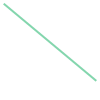

In [20]:
coords = [[-113.2, 37.45], [-112.9, 37.2]]
zion_transect = shapely.geometry.LineString(coords)
zion_transect

这是一个打印输出，证明这是一个代表两点之间直线的“LineString”几何图形：

In [21]:
print(zion_transect)

LINESTRING (-113.2 37.45, -112.9 37.2)


该线在@fig-zion-transect 中的栅格上下文中进行了说明。

通过想象您正在计划徒步旅行来说明从线性选择器提取高度的实用性。
下面演示的方法提供了路线的“海拔剖面”（路线不需要是直的），可用于估计由于长途爬升而需要多长时间。

首先，我们需要创建一个图层“zion_transect_pnt”，由沿线（“zion_transect”）以指定间隔（“distance_delta”）的点组成。 为此，我们需要将直线转换为投影 CRS（以便我们使用真实距离，以 $m$ 为单位），例如 UTM。 这需要通过“GeoSeries”，因为“shapely”几何图形没有 CRS 定义，也没有重投影的概念（请参阅@sec-vector-layer-from-scratch）：


In [22]:
zion_transect_utm = gpd.GeoSeries(zion_transect, crs=4326)
zion_transect_utm = zion_transect_utm.to_crs(32612)
zion_transect_utm = zion_transect_utm.iloc[0]

新几何的打印输出显示这仍然是两点之间的直线，只是坐标在不同的 CRS 中：

In [23]:
print(zion_transect_utm)

LINESTRING (305399.6720818058 4147066.650206682, 331380.8917453843 4118750.094788485)


然后，我们使用“np.arange”计算沿线生成点的距离。 这是一个从“0”开始的数字序列，一直到“.length”行，步长为 250 ($m$)：

In [24]:
distances = np.arange(0, zion_transect_utm.length, 250)
distances[:7]  ## First 7 distance cutoff points

array([   0.,  250.,  500.,  750., 1000., 1250., 1500.])

距离截止用于沿线采样（“插值”）点。 “shapely”方法“line.interpolate(d)”用于生成点。 然后将这些点重新投影回栅格的 CRS：

In [25]:
zion_transect_pnt = [zion_transect_utm.interpolate(distance) for distance in distances]
zion_transect_pnt = gpd.GeoSeries(zion_transect_pnt, crs=32612)
zion_transect_pnt = zion_transect_pnt.to_crs(4326)
zion_transect_pnt

0      POINT (-113.20000 37.45000)
1      POINT (-113.19804 37.44838)
2      POINT (-113.19608 37.44675)
                  ...             
151    POINT (-112.90529 37.20443)
152    POINT (-112.90334 37.20280)
153    POINT (-112.90140 37.20117)
Length: 154, dtype: geometry

其次，我们提取横断面中每个点的高程值，并将这些信息与“zion_transect_pnt”结合起来（在将其“提升”为“GeoDataFrame”之后，以容纳额外的属性），使用前面所示的点提取方法（@sec-extraction） - 到点）。 我们还附加了各自的距离截止点“distances”：

In [26]:
result = rasterstats.point_query(
    zion_transect_pnt, 
    src_srtm.read(1), 
    nodata = src_srtm.nodata, 
    affine = src_srtm.transform,
    interpolate='nearest'
)
zion_transect_pnt = gpd.GeoDataFrame(geometry=zion_transect_pnt)
zion_transect_pnt['dist'] = distances
zion_transect_pnt['elev'] = result
zion_transect_pnt

,geometry,dist,elev
0,POINT (-113.20000 37.45000),0.0,2001
1,POINT (-113.19804 37.44838),250.0,2037
2,POINT (-113.19608 37.44675),500.0,1949
...,...,...,...
151,POINT (-112.90529 37.20443),37750.0,1837
152,POINT (-112.90334 37.20280),38000.0,1841
153,POINT (-112.90140 37.20117),38250.0,1819


`zion_transect_pnt` 中的信息，即 `"dist"` 和 `"elev"` 属性，现在可用于创建高程剖面，如 @fig-zion-transect 所示：

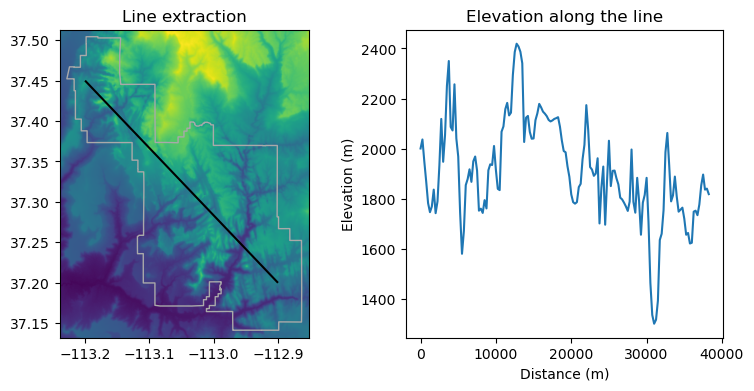

In [27]:
#| label: fig-zion-transect
#| fig-cap: Location of a line used for raster extraction (left) and the elevation along this line (right). 

fig, axes = plt.subplots(ncols=2, figsize=(9,4))
rasterio.plot.show(src_srtm, ax=axes[0])
gpd.GeoSeries(zion_transect).plot(ax=axes[0], color='black')
zion.plot(ax=axes[0], color='none', edgecolor='darkgrey')
zion_transect_pnt.set_index('dist')['elev'].plot(ax=axes[1])
axes[1].set_xlabel('Distance (m)')
axes[1].set_ylabel('Elevation (m)')
axes[0].set_title('Line extraction')
axes[1].set_title('Elevation along the line');

### 提取多边形

用于栅格提取的地理矢量对象的最终类型是多边形。
与线一样，多边形往往会为每个多边形返回许多栅格值。
通常，我们会生成每个多边形的栅格值的汇总统计数据，例如用于表征单个区域或比较多个区域。
下面的代码演示了通过多边形生成栅格汇总统计数据，该代码创建了一个汇总统计数据列表（在本例中，长度为 1 的列表，因为只有一个多边形），再次使用“rasterstats”：


In [28]:
rasterstats.zonal_stats(
    zion, 
    src_srtm.read(1), 
    nodata = src_srtm.nodata, 
    affine = src_srtm.transform, 
    stats = ['mean', 'min', 'max']
)

[{'min': 1122.0, 'max': 2661.0, 'mean': 1818.211830154405}]

结果提供了有用的摘要，例如，公园内的最大高度约为海拔 2,661 米（其他摘要统计数据，例如标准偏差，也可以通过这种方式计算）。
由于示例中只有一个多边形，因此返回单行数据框； 然而，当使用多个选择器多边形时，该方法有效。

请注意“stats”参数，我们在其中确定每个多边形计算的统计数据类型。
除“mean”、“min”、“max”之外的可能值有：

* `'count'`——有效（即不包括“无数据”）像素的数量
* `'nodata'`—“无数据”的像素数
* `'majority'`——最常出现的值
* `'median'`——中值

有关完整列表，请参阅[文档](https://pythonhosted.org/rasterstats/manual.html#statistics)。
此外，“zonal_stats”函数接受用户定义的函数来计算任何自定义统计数据。

要计算多边形内分类栅格值的出现次数，我们可以使用掩码（请参阅第...节）与“np.unique”相结合，如下所示：

In [29]:
out_image, out_transform = rasterio.mask.mask(
    src_nlcd, 
    zion['geometry'].to_crs(src_nlcd.crs), 
    crop=False, 
    nodata=9999
)
counts = np.unique(out_image, return_counts=True)

根据结果，例如，像素值“2”（“开发”类）出现在 Zion 多边形内的“4205”像素中：

In [32]:
counts

(array([ 2,  3,  4,  5,  6,  7,  8, 15], dtype=uint8),
 array([  4205,  98285, 298299, 203701,    235,     62,    679, 852741],
       dtype=int64))

栅格到多边形的提取在 @fig-raster-extract-to-polygon 中进行了说明。

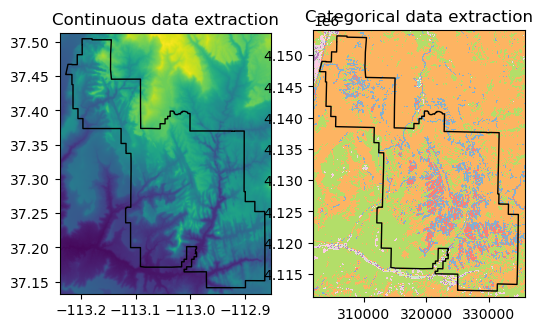

In [33]:
#| label: fig-raster-extract-to-polygon
#| fig-cap: Area used for continuous (left) and categorical (right) raster extraction.

fig, axes = plt.subplots(ncols=2, figsize=(6,4))
rasterio.plot.show(src_srtm, ax=axes[0])
zion.plot(ax=axes[0], color='none', edgecolor='black')
rasterio.plot.show(src_nlcd, ax=axes[1], cmap='Set3')
zion.to_crs(src_nlcd.crs).plot(ax=axes[1], color='none', edgecolor='black')
axes[0].set_title('Continuous data extraction')
axes[1].set_title('Categorical data extraction');

## 光栅化

光栅化是将矢量对象转换为光栅对象的表示形式。 通常，输出栅格用于定量分析（例如地形分析）或建模。 正如我们在第 2 章中看到的，栅格数据模型具有一些使其有利于某些方法的特征。 此外，栅格化过程可以帮助简化数据集，因为结果值都具有相同的空间分辨率：栅格化可以被视为一种特殊类型的地理数据聚合。

`rasterio` 包包含用于执行此工作的 `rasterio.features.rasterize` 函数。 为了实现这一点，我们需要有“模板”网格定义，即定义输出的范围、分辨率和 CRS 的“模板”栅格，其形式为“out_shape”（尺寸）和“transform”（ 变换）。 如果我们有一个现有的模板栅格，我们只需查询它的“out_shape”和“transform”。 如果我们创建自定义模板，例如，以指定的分辨率覆盖矢量图层范围，则需要一些额外的工作来计算“out_shape”和“transform”（请参见下一个示例）。

此外，“rasterio.features.rasterize”函数需要“(geom, value)”元组生成器形式的输入形状，其中：

* `geom` 是给定的几何形状 (`shapely`)
* `value` 是要“刻录”为与几何形状一致的像素的值（`int` 或 `float`）

同样，这将在下一个示例中阐明。

“模板”栅格的地理分辨率对结果有重大影响：如果太低（像元大小太大），结果可能会错过矢量数据的完整地理变化； 如果太高，计算时间可能会过多。 在决定适当的地理分辨率时没有简单的规则可遵循，这在很大程度上取决于结果的预期用途。 通常，目标分辨率是强加给用户的，例如当光栅化的输出需要与现有光栅对齐时。

为了演示栅格化的实际应用，我们将使用与输入矢量数据“cycle_hire_osm_projected”具有相同范围和 CRS 的模板栅格（@fig-rasterize-points 中说明了伦敦自行车租赁点的数据集）和空间分辨率 1000米。 首先，我们得到矢量图层：

In [34]:
cycle_hire_osm_projected = cycle_hire_osm.to_crs(27700)
cycle_hire_osm_projected

,osm_id,name,capacity,cyclestreets_id,description,geometry
0,108539,Windsor Terrace,14.0,None,None,POINT (532353.838 182857.655)
1,598093293,"Pancras Road, King's Cross",NaN,None,None,POINT (529848.350 183337.175)
2,772536185,"Clerkenwell, Ampton Street",11.0,None,None,POINT (530635.620 182608.992)
...,...,...,...,...,...,...
537,5121513755,None,5.0,None,None,POINT (532531.241 178805.391)
538,5188912370,None,NaN,None,None,POINT (538723.338 180836.279)
539,5188912371,None,NaN,None,None,POINT (538413.214 180774.335)


接下来，我们需要计算出模板栅格的“out_shape”和“transform”。 为了计算变换，我们将“cycle_hire_osm_projected”边界框的左上角与所需的分辨率（例如，1000 $m$）相结合：

In [35]:
bounds = cycle_hire_osm_projected.total_bounds
bounds

array([523038.61452275, 174934.65727249, 538723.33812747, 184971.40854298])

In [36]:
res = 1000
transform = rasterio.transform.from_origin(
    west=bounds[0], 
    north=bounds[3], 
    xsize=res, 
    ysize=res
)
transform

Affine(1000.0, 0.0, 523038.6145227547,
       0.0, -1000.0, 184971.40854297992)

为了计算“out_shape”，我们将 x 轴和 y 轴范围除以分辨率：

In [37]:
rows = math.ceil((bounds[3] - bounds[1]) / res)
cols = math.ceil((bounds[2] - bounds[0]) / res)
shape = (rows, cols)
shape

(11, 16)

现在，我们可以光栅化。 栅格化是一种非常灵活的操作：结果不仅取决于模板栅格的性质，还取决于输入矢量的类型（例如，点、多边形）、像素“激活”方法以及存在时应用的函数。 不止一场比赛。

为了说明这种灵活性，我们将尝试三种不同的光栅化方法。 首先，我们创建一个表示自行车租赁点是否存在的栅格（称为存在/不存在栅格）。 在这种情况下，我们将值“1”传输到至少有一个点落入的所有像素。为了将点“GeoDataFrame”转换为“shapely”几何图形和（固定）值的生成器，我们使用以下表达式 :

In [38]:
((g, 1) for g in cycle_hire_osm_projected['geometry'].to_list())

<generator object <genexpr> at 0x000002019B19F890>

因此，光栅化表达式为：

In [39]:
ch_raster1 = rasterio.features.rasterize(
    ((g, 1) for g in cycle_hire_osm_projected['geometry'].to_list()),
    out_shape=shape,
    transform=transform
)

结果是一个“numpy”数组，其中烧录值为“1”，未受影响的“像素”中为“0”：

In [40]:
ch_raster1

array([[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

为了统计站点的数量，我们可以使用固定值“1”与“merge_alg=rasterio.enums.MergeAlg.add”相结合，这意味着烧录到同一像素的多个值将被*求和*，而不是被替换 保持最后（默认）：

In [41]:
ch_raster2 = rasterio.features.rasterize(
    ((g, 1) for g in cycle_hire_osm_projected['geometry'].to_list()),
    out_shape=shape,
    transform=transform,
    merge_alg=rasterio.enums.MergeAlg.add
)

这是计数结果数组：

In [42]:
ch_raster2

array([[ 0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  1,  3,  3],
       [ 0,  0,  0,  1,  3,  3,  5,  5,  8,  9,  1,  3,  2,  6,  7,  0],
       [ 0,  0,  0,  8,  5,  4, 11, 10, 12,  9, 11,  4,  8,  5,  4,  0],
       [ 0,  1,  4, 10, 10, 11, 18, 16, 13, 12,  8,  6,  5,  2,  3,  0],
       [ 3,  3,  9,  3,  5, 14, 10, 15,  9,  9,  5,  8,  0,  0, 12,  2],
       [ 4,  5,  9, 11,  6,  7,  7,  3, 10,  9,  4,  0,  0,  0,  0,  0],
       [ 4,  0,  7,  8,  8,  4, 11, 10,  7,  3,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  3,  0,  0,  1,  4,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  1,  0,  1,  0,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]],
      dtype=uint8)

新输出“ch_raster2”显示每个网格单元中的自行车租赁点的数量。 自行车租赁地点有不同数量的自行车，由容量变量描述，这就提出了一个问题：每个网格单元的容量是多少？ 为了计算它，我们必须对字段（“容量”）而不是固定值“1”求和。 这需要使用扩展的几何图形和值生成器，其中我们（1）提取几何图形和属性值，以及（2）过滤掉“无数据”值，如下所示：

In [43]:
ch_raster3 = rasterio.features.rasterize(
    ((g, v) for g, v in cycle_hire_osm_projected[['geometry', 'capacity']] \
        .dropna(subset='capacity')
        .to_numpy() \
        .tolist()),
    out_shape=shape,
    transform=transform,
    merge_alg=rasterio.enums.MergeAlg.add
)

以下是说明输入点图层“cycle_hire_osm_projected”以及栅格化它的三种变体“ch_raster1”、“ch_raster2”和“ch_raster3”的代码（@fig-rasterize-points）：

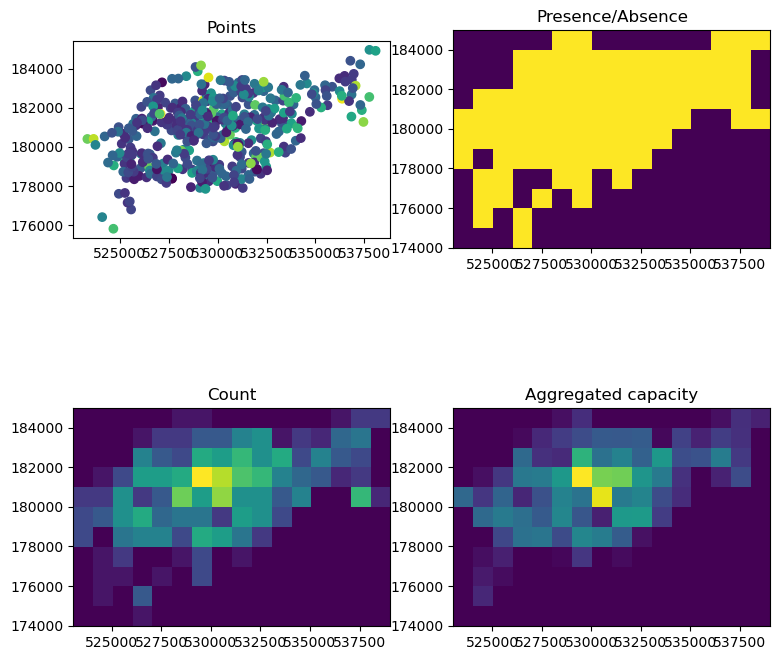

In [44]:
#| label: fig-rasterize-points
#| fig-cap: Examples of point rasterization.

fig, axes = plt.subplots(2, 2, figsize=(9, 9))
cycle_hire_osm_projected.plot(ax=axes[0][0], column='capacity')
show(ch_raster1, transform=transform, ax=axes[0][1])
show(ch_raster2, transform=transform, ax=axes[1][0])
show(ch_raster3, transform=transform, ax=axes[1][1])
axes[0][0].set_title('Points')
axes[0][1].set_title('Presence/Absence')
axes[1][0].set_title('Count')
axes[1][1].set_title('Aggregated capacity');

## 空间矢量化

空间矢量化与光栅化（第...节）相对应，但方向相反。 它涉及将空间连续的栅格数据转换为空间离散的矢量数据，例如点、线或多边形。

将栅格转换为矢量图层有三种标准方法：

* 光栅到多边形
* 光栅到点
* 光栅到轮廓

矢量化最直接的形式是第一种，将栅格单元转换为多边形，其中每个像素由矩形多边形表示。 第二种方法，栅格到点，有计算多边形质心的附加步骤。 第三种方法，栅格到等高线，有点不相关。 让我们按给定的顺序演示这三个。

`rasterio.features.shapes` 函数可用于访问作为多边形几何形状的栅格像素以及栅格值。 返回的对象是一个生成器，它生成“几何，值”对。 附加的“transform”参数用于生成多边形的真实空间坐标，这通常是我们想要的。

例如，以下表达式返回一个名为“shapes”的生成器，引用像素多边形：

In [45]:
shapes = rasterio.features.shapes(src_grain.read(), transform=src_grain.transform)
shapes

<generator object shapes at 0x000002019B53D7B0>

我们可以一次生成所有形状，放入名为“pol”的“列表”中，如下所示：

In [46]:
pol = list(shapes)

`pol` 中的每个元素都是一个长度为 2 的 `tuple`，包含：

* 类似 GeoJSON 的 `dict` 表示多边形几何形状
* 构成多边形的像素值

例如：

In [47]:
pol[0]

({'type': 'Polygon',
  'coordinates': [[(-1.5, 1.5),
    (-1.5, 1.0),
    (-1.0, 1.0),
    (-1.0, 1.5),
    (-1.5, 1.5)]]},
 1.0)

请注意，每个栅格单元都转换为由五个坐标组成的多边形，所有这些坐标都存储在内存中（解释了为什么栅格通常比矢量更快！）。

要将“list”转换为“GeoDataFrame”，我们还需要几个数据重塑步骤：

In [48]:
# Create 'GeoSeries' with the polygons
geom = [shapely.geometry.shape(i[0]) for i in pol]
geom = gpd.GeoSeries(geom, crs=src_grain.crs)
# Create 'Series' with the values
values = [i[1] for i in pol]
values = pd.Series(values)
# Combine the 'Series' and 'GeoSeries' into a 'DataFrame'
result = gpd.GeoDataFrame({'value': values, 'geometry': geom})
result

,value,geometry
0,1.0,"POLYGON ((-1.50000 1.50000, -1...."
1,0.0,"POLYGON ((-1.00000 1.50000, -1...."
2,1.0,"POLYGON ((-0.50000 1.50000, -0...."
...,...,...
11,2.0,"POLYGON ((0.00000 -0.50000, 0.0..."
12,0.0,"POLYGON ((0.50000 -1.00000, 0.5..."
13,2.0,"POLYGON ((1.00000 -1.00000, 1.0..."


生成的多边形图层显示在 @fig-raster-to-polygons 中。 如使用“edgecolor='black'”选项所示，共享相同栅格值的相邻像素被分解为更大的多边形。 `rasterio.features.shapes` 函数没有提供避免这种类型溶解的方法。 解决此问题的一种方法是将具有连续 ID（而不是实际值）的数组转换为多边形，然后从栅格中提取实际值（类似于“栅格到点”示例，请参见下文）。

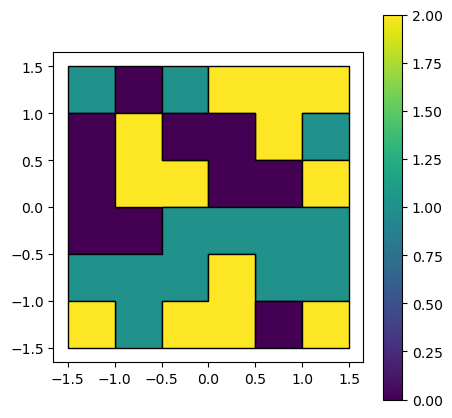

In [49]:
#| label: fig-raster-to-polygons
#| fig-cap: grain.tif converted to polygon layer

result.plot(column='value', edgecolor='black', legend=True);

要将栅格转换为点，我们可以使用“rasterio.features.shapes”，就像转换为多边形一样，只需添加“.centroid”方法即可从多边形到其质心。 然而，为了避免溶解附近的像素，我们实际上将转换具有连续 ID 的栅格，然后逐点提取“真实”值（在本示例中并非绝对必要，因为 `elev.tif` 的值都是唯一的） :

In [50]:
# Prepare IDs array
r = src_elev.read(1)
ids = r.copy()
ids = np.arange(0, r.size).reshape(r.shape).astype(np.int32)
ids

array([[ 0,  1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10, 11],
       [12, 13, 14, 15, 16, 17],
       [18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35]])

In [51]:
# IDs raster to points
shapes = rasterio.features.shapes(ids, transform=src_elev.transform)
pol = list(shapes)
geom = [shapely.geometry.shape(i[0]).centroid for i in pol]
geom = gpd.GeoSeries(geom, crs=src_elev.crs)
result = gpd.GeoDataFrame(geometry=geom)

In [52]:
# Extract values to points
result['value'] = rasterstats.point_query(
    result, 
    r, 
    nodata = src_elev.nodata, 
    affine = src_elev.transform,
    interpolate='nearest'
)

d:\work\miniconda3\lib\site-packages\rasterstats\io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


结果显示在 @fig-raster-to-points 中。

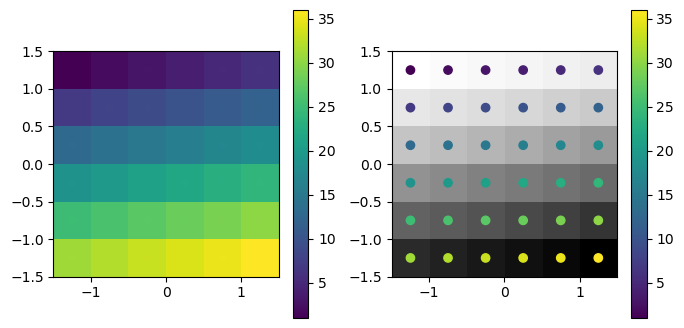

In [53]:
#| label: fig-raster-to-points
#| fig-cap: Raster and point representation of the `elev.tif`.

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
result.plot(column='value', legend=True, ax=axes[0]);
show(src_elev, transform=src_elev.transform, ax=axes[0])
result.plot(column='value', legend=True, ax=axes[1]);
show(src_elev, cmap='Greys', ax=axes[1]);

另一种常见的空间矢量化类型是创建表示连续高度或温度（等温线）的线的等高线。 我们将使用现实世界的数字高程模型（DEM），因为人工光栅高程会产生平行线（读者的任务：验证这一点并解释为什么会发生这种情况）。 绘制等高线很简单，使用 rasterio.plot.show (@fig-raster-contours1) 的 `contour=True` 选项：

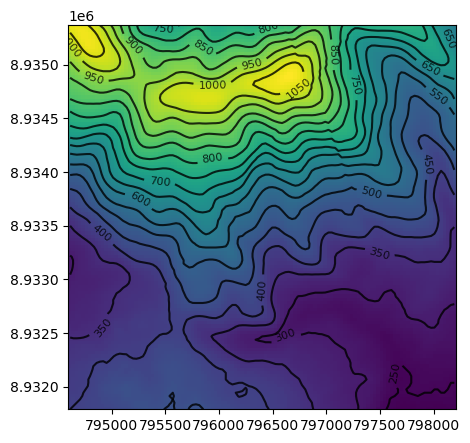

In [56]:
#| label: fig-raster-contours1
#| fig-cap: Displaying raster contours

fig, ax = plt.subplots(1)
rasterio.plot.show(src_dem, ax=ax)
rasterio.plot.show(src_dem, ax=ax, contour=True, levels=np.arange(0,1200,50), colors='black');

不幸的是，“rasterio”不提供任何以矢量图层形式提取等高线的方法，用于绘图以外的用途。 有两种可能的解决方法：

1. 在[命令行](https://gdal.org/programs/gdal_contour.html)上使用`gdal_contour`（见下文），或通过其Python接口[`osgeo`](https://gis.stackexchange .com/questions/360431/how-can-i-create-contours-from-geotiff-and-python-gdal-rasterio-etc-into-sh)
1. 编写自定义函数来导出由 [`matplotlib`](https://www.tutorialspoint.com/how-to-get-coordinates-from-the-contour-in-matplotlib) 或 [`skimage`](https://gis.stackexchange.com/questions/268331/how-can-i-extract-contours-from-a-raster-with-python)

我们特此演示第一种也是最简单的方法，使用“gdal_contour”。 尽管我们没有专门使用 Python 语言，但“gdal_contour”的好处是经过验证的算法，针对空间数据进行定制，并具有许多相关选项。 `gdal_contour` （以及其他 GDAL 程序）应该已经安装在您的系统上，因为这是 `rasterio` 的依赖项。 例如，生成“dem.tif”文件的 50 $m$ 轮廓可以按如下方式完成：

In [59]:
os.system('gdal_contour -a elev data/dem.tif output/dem_contour.gpkg -i 50.0')

0

请注意，我们通过“os.system”运行“gdal_contour”命令，以便保留在 Python 环境中。 您还可以在正在使用的命令行界面中运行独立命令，例如 Anaconda Prompt：

```sh
gdal_contour -a elev data/dem.tif output/dem_contour.gpkg -i 50.0
```

与所有 GDAL 程序一样，“gdal_contour”也适用于文件。 这里：

* 输入是`data/dem.tif`文件
* 结果导出到`output/dem_contour.gpkg`文件

为了说明结果，让我们将结果读回到 Python 环境中。 请注意，该图层包含一个名为“elev”的 Arrtibute（使用“-a elev”指定）以及等高线高程值：

In [60]:
contours = gpd.read_file('output/dem_contour.gpkg')
contours

,ID,elev,geometry
0,0,750.0,LINESTRING (795382.355 8935384....
1,1,800.0,LINESTRING (795237.703 8935384....
2,2,650.0,LINESTRING (798098.379 8935384....
...,...,...,...
29,29,450.0,LINESTRING (795324.083 8931774....
30,30,450.0,LINESTRING (795488.616 8931774....
31,31,450.0,LINESTRING (795717.420 8931774....


这是“dem_contour.gpkg”（@fig-raster-contours2）中的等值线图层图：

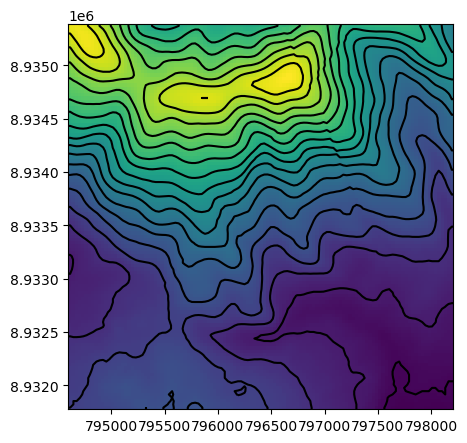

In [61]:
#| label: fig-raster-contours2
#| fig-cap: Raster contours calculated with the `gdal_contour` program

fig, ax = plt.subplots()
rasterio.plot.show(src_dem, ax=ax)
contours.plot(ax=ax, edgecolor='black');